In [1]:
import time
import itertools
import time, os, fnmatch, shutil
import pickle
import re
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

%matplotlib inline

from __future__ import print_function, division
import requests

In [2]:
pkl_filename_master = "IP_OP_Hosp_df.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_alldata = pickle.load(picklefile)

In [3]:
df_alldata.dtypes

Average_Covered_Charges                       float64
Average_Medicare_Payments                     float64
Average_Total_Payments                        float64
DRG_Definition                                 object
Hospital_Referral_Region_(HRR)_Description     object
Provider_City                                  object
Provider_ID                                     int64
Provider_Name                                  object
Provider_State                                 object
Provider_Street_Address                        object
Provider_Zip_Code                               int64
Service_type                                   object
Total_Discharges                                int64
Hospital_Name                                  object
County_Name                                    object
Hospital_Type                                  object
Hospital_Ownership                             object
Emergency_Services                             object
dtype: object

Calculate the OOP for patients for IP stays

In [4]:
#df_IPandProvider['Average_Total_Payments'].iloc[1] - df_IPandProvider['Average_Medicare_Payments'].iloc[1]
df_alldata['Patient_payment'] = df_alldata['Average_Total_Payments'] - df_alldata['Average_Medicare_Payments']


Look at how data is distributed for a few of the tags

In [5]:
stats = df_alldata[df_alldata.DRG_Definition == '885 - PSYCHOSES'].mean()

In [6]:
stats

Average_Covered_Charges       23962.716435
Average_Medicare_Payments      6897.348952
Average_Total_Payments         8465.983557
Provider_ID                  250526.132045
Provider_Zip_Code             47615.636071
Total_Discharges                141.613527
Patient_payment                1568.634605
dtype: float64

In [7]:
medians = df_alldata[df_alldata.DRG_Definition == '885 - PSYCHOSES'].median()

In [8]:
medians

Average_Covered_Charges       19239.071430
Average_Medicare_Payments      6032.555944
Average_Total_Payments         7325.500000
Provider_ID                  230230.000000
Provider_Zip_Code             44903.000000
Total_Discharges                 93.000000
Patient_payment                1164.962406
dtype: float64

In [9]:
stats[(0)]

23962.716435193241

In [10]:
medians[(0)]

19239.07143

23962.71643519324

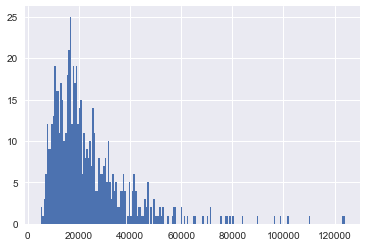

In [11]:
df_Psych = df_alldata[df_alldata.DRG_Definition == '885 - PSYCHOSES']
df_Psych['Average_Covered_Charges'].hist(bins = 200)
df_Psych['Average_Covered_Charges'].mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


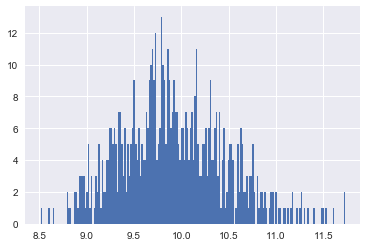

In [12]:
df_Psych['log_Average_Covered_Charges'] = np.log(df_Psych['Average_Covered_Charges'])
df_Psych['log_Average_Covered_Charges'].hist(bins = 200)

101446.8696582755

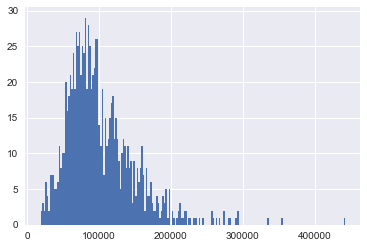

In [13]:
df_vasc = df_alldata[df_alldata.DRG_Definition == '252 - OTHER VASCULAR PROCEDURES W MCC']
df_vasc['Average_Covered_Charges'].hist(bins = 200)
df_vasc['Average_Covered_Charges'].mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


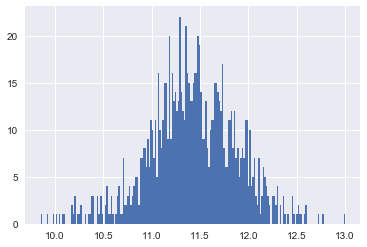

In [14]:
df_vasc['log_Average_Covered_Charges'] = np.log(df_vasc['Average_Covered_Charges'])
df_vasc['log_Average_Covered_Charges'].hist(bins = 200)

179.38889725236777

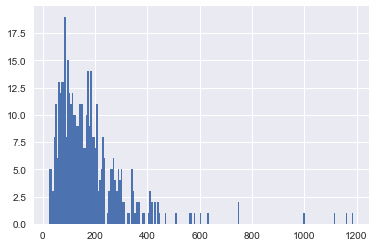

In [15]:
df_debride = df_alldata[df_alldata.DRG_Definition == '0012 - Level I Debridement & Destruction']
df_debride['Average_Covered_Charges'].hist(bins = 200)
df_debride['Average_Covered_Charges'].mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


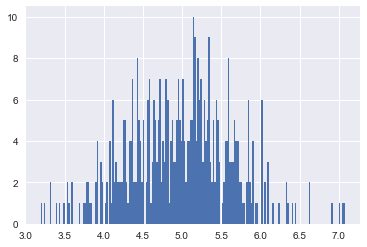

In [16]:
df_debride['log_Average_Covered_Charges'] = np.log(df_debride['Average_Covered_Charges'])
df_debride['log_Average_Covered_Charges'].hist(bins = 200)

Log is definitley much more normal for the data. Add log colums to dataset in case useful later on. 

In [17]:
df_alldata.columns

Index([u'Average_Covered_Charges', u'Average_Medicare_Payments',
       u'Average_Total_Payments', u'DRG_Definition',
       u'Hospital_Referral_Region_(HRR)_Description', u'Provider_City',
       u'Provider_ID', u'Provider_Name', u'Provider_State',
       u'Provider_Street_Address', u'Provider_Zip_Code', u'Service_type',
       u'Total_Discharges', u'Hospital_Name', u'County_Name', u'Hospital_Type',
       u'Hospital_Ownership', u'Emergency_Services', u'Patient_payment'],
      dtype='object')

Replace 0's with 1's so we can take the log

In [18]:
df_alldata['Average_Medicare_Payments'] = df_alldata['Average_Medicare_Payments'].replace('0',int(1))

In [19]:
df_alldata['Patient_payment'] = df_alldata['Patient_payment'].replace('0',int(1))

In [20]:
df_alldata['log_Average_Covered_Charges'] = np.log(df_alldata['Average_Covered_Charges'])

In [21]:
df_alldata['log_Average_Medicare_Payments'] = np.log(df_alldata['Average_Medicare_Payments'])

In [22]:
df_alldata['log_Average_Total_Payments'] = np.log(df_alldata['Average_Total_Payments'])

In [23]:
df_alldata['log_Patient_payment'] = np.log(df_alldata['Patient_payment'])

Now get stats for the types of services provided:

In [24]:
df_alldata['Average_Covered_Charges'].groupby([df_alldata['DRG_Definition'],df_alldata['Provider_State']]).mean()


DRG_Definition                                                             Provider_State
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC             AL                1.172866e+06
                                                                           AZ                4.375313e+05
                                                                           CA                1.642007e+06
                                                                           CT                8.257015e+05
                                                                           DC                7.807814e+05
                                                                           FL                7.843003e+05
                                                                           GA                7.148593e+05
                                                                           IL                8.938851e+05
                                                              

In [25]:
df_alldata.columns

Index([u'Average_Covered_Charges', u'Average_Medicare_Payments',
       u'Average_Total_Payments', u'DRG_Definition',
       u'Hospital_Referral_Region_(HRR)_Description', u'Provider_City',
       u'Provider_ID', u'Provider_Name', u'Provider_State',
       u'Provider_Street_Address', u'Provider_Zip_Code', u'Service_type',
       u'Total_Discharges', u'Hospital_Name', u'County_Name', u'Hospital_Type',
       u'Hospital_Ownership', u'Emergency_Services', u'Patient_payment',
       u'log_Average_Covered_Charges', u'log_Average_Medicare_Payments',
       u'log_Average_Total_Payments', u'log_Patient_payment'],
      dtype='object')

Calculate the average, mean and stdev  for each payment and log payment type by service type

In [26]:

stats_calc = ['Average_Covered_Charges','Average_Medicare_Payments','Average_Total_Payments',\
              'Patient_payment','log_Average_Covered_Charges','log_Average_Medicare_Payments',\
              'log_Average_Total_Payments', 'log_Patient_payment']
    
for column in stats_calc:
    df_alldata = df_alldata.join(df_alldata.groupby('DRG_Definition')[column].mean(), on='DRG_Definition', rsuffix='_mean')
    df_alldata = df_alldata.join(df_alldata.groupby('DRG_Definition')[column].median(), on='DRG_Definition', rsuffix='_median')
    df_alldata =df_alldata.join(df_alldata.groupby('DRG_Definition')[column].std(), on='DRG_Definition', rsuffix='_std')


In [27]:

for column in stats_calc:
    df_alldata = df_alldata.join(df_alldata.groupby(['DRG_Definition','Provider_State'])[column].mean(), on=['DRG_Definition','Provider_State'], rsuffix='_ST_mean')
    df_alldata = df_alldata.join(df_alldata.groupby(['DRG_Definition','Provider_State'])[column].mean(), on=['DRG_Definition','Provider_State'], rsuffix='_ST_median')
    df_alldata = df_alldata.join(df_alldata.groupby(['DRG_Definition','Provider_State'])[column].mean(), on=['DRG_Definition','Provider_State'], rsuffix='_ST_std')


In [28]:
 df_alldata.columns

Index([u'Average_Covered_Charges', u'Average_Medicare_Payments',
       u'Average_Total_Payments', u'DRG_Definition',
       u'Hospital_Referral_Region_(HRR)_Description', u'Provider_City',
       u'Provider_ID', u'Provider_Name', u'Provider_State',
       u'Provider_Street_Address', u'Provider_Zip_Code', u'Service_type',
       u'Total_Discharges', u'Hospital_Name', u'County_Name', u'Hospital_Type',
       u'Hospital_Ownership', u'Emergency_Services', u'Patient_payment',
       u'log_Average_Covered_Charges', u'log_Average_Medicare_Payments',
       u'log_Average_Total_Payments', u'log_Patient_payment',
       u'Average_Covered_Charges_mean', u'Average_Covered_Charges_median',
       u'Average_Covered_Charges_std', u'Average_Medicare_Payments_mean',
       u'Average_Medicare_Payments_median', u'Average_Medicare_Payments_std',
       u'Average_Total_Payments_mean', u'Average_Total_Payments_median',
       u'Average_Total_Payments_std', u'Patient_payment_mean',
       u'Patient_payment_

In [63]:
# #If wanted to do this by dictionary

# covered_charges_dict = {}
# total_payments_dict = {}
# medicare_payments_dict = {}
# patient_payments_dict = {}

# for charge_type in df_IPandProvider.DRG_Definition.unique():
    
#     if covered_charges_dict.has_key(charge_type):
#         pass
#     else:
#         stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
#         stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
#         medians = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].median()
#         covered_charges_dict[charge_type] = [stats[(0)],medians[(0)], stdev[(0)]]
        
#     if total_payments_dict.has_key(charge_type):
#         pass
#     else:
#         stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
#         stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
#         medians = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].median()
#         total_payments_dict[charge_type] = [stats[(2)],medians[(2)],stdev[(2)]]
        
#     if medicare_payments_dict.has_key(charge_type):
#         pass
#     else:
#         stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
#         stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
#         medians = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].median()
#         medicare_payments_dict[charge_type] = [stats[(1)],medians[(1)],stdev[(1)]]
          
#     if patient_payments_dict.has_key(charge_type):
#         pass
#     else:
#         stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
#         stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
#         medians = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].median()
#         patient_payments_dict[charge_type] = [stats[(6)],medians[(1)],stdev[(6)]]
        
    

In [170]:
# patient_payments_dict['252 - OTHER VASCULAR PROCEDURES W MCC']
# patient_payments_dict['0012 - Level I Debridement & Destruction']
# patient_payments_dict['885 - PSYCHOSES']


This one will calculate 3 bins at the national and state level for un-transformed data:

In [73]:
# df_check = df_alldata.copy()
# df_check = df_check.sample(50).reset_index()
# df_check

,index,Average_Covered_Charges,Average_Medicare_Payments,Average_Total_Payments,DRG_Definition,Hospital_Referral_Region_(HRR)_Description,Provider_City,Provider_ID,Provider_Name,Provider_State,...,log_Average_Covered_Charges_ST_std,log_Average_Medicare_Payments_ST_mean,log_Average_Medicare_Payments_ST_median,log_Average_Medicare_Payments_ST_std,log_Average_Total_Payments_ST_mean,log_Average_Total_Payments_ST_median,log_Average_Total_Payments_ST_std,log_Patient_payment_ST_mean,log_Patient_payment_ST_median,log_Patient_payment_ST_std
0,24399,18162.214290,5102.571429,6032.571429,176 - PULMONARY EMBOLISM W/O MCC,NC - Winston-Salem,HIGH POINT,340004,HIGH POINT REGIONAL HOSPITAL,NC,...,9.910627,8.576540,8.576540,8.576540,8.832331,8.832331,8.832331,7.301053,7.301053,7.301053
1,69481,54240.269230,10384.807690,11420.076920,"281 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...",CA - Sacramento,SACRAMENTO,50108,SUTTER GENERAL HOSPITAL,CA,...,10.898739,8.996403,8.996403,8.996403,9.143342,9.143342,9.143342,7.075115,7.075115,7.075115
2,117129,27981.809520,4591.119048,5507.690476,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",TN - Memphis,CLARKSDALE,250042,NORTHWEST MISSISSIPPI REGIONAL MEDICAL CENTER,MS,...,9.710593,8.264618,8.264618,8.264618,8.516118,8.516118,8.516118,6.993845,6.993845,6.993845
3,104908,52588.357140,12456.642860,12888.571430,374 - DIGESTIVE MALIGNANCY W MCC,NE - Omaha,OMAHA,280040,THE NEBRASKA METHODIST HOSPITAL,NE,...,10.870250,9.430009,9.430009,9.430009,9.464096,9.464096,9.464096,6.068260,6.068260,6.068260
4,205515,770.800000,1.000000,161.037333,0015 - Level III Debridement & Destruction,CA - San Diego,SAN DIEGO,50077,SCRIPPS MERCY HOSPITAL,CA,...,6.397170,0.000000,0.000000,0.000000,5.134885,5.134885,5.134885,5.134885,5.134885,5.134885
5,9724,46150.379310,9408.954023,12612.574710,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,VA - Richmond,RICHMOND,490032,MEDICAL COLLEGE OF VIRGINIA HOSPITALS,VA,...,10.105421,8.594909,8.594909,8.594909,8.854034,8.854034,8.854034,7.337091,7.337091,7.337091
6,140188,43520.833330,9328.666667,10509.708330,482 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,NJ - Camden,FREEHOLD,310111,CENTRASTATE MEDICAL CENTER,NJ,...,10.993299,9.221089,9.221089,9.221089,9.391111,9.391111,9.391111,7.411422,7.411422,7.411422
7,215052,1597.325172,1.000000,328.507586,0206 - Level II Nerve Injections,OH - Columbus,PORTSMOUTH,360008,SOUTHERN OHIO MEDICAL CENTER,OH,...,7.375344,0.000000,0.000000,0.000000,5.736321,5.736321,5.736321,5.736321,5.736321,5.736321
8,119193,149125.200000,16699.600000,18173.333330,393 - OTHER DIGESTIVE SYSTEM DIAGNOSES W MCC,TX - Fort Worth,ARLINGTON,450675,MEDICAL CENTER OF ARLINGTON,TX,...,10.846733,9.231315,9.231315,9.231315,9.364389,9.364389,9.364389,7.099130,7.099130,7.099130
9,66148,49367.333330,15229.285710,16950.714290,253 - OTHER VASCULAR PROCEDURES W CC,ND - Fargo/Moorhead MN,FARGO,350070,ESSENTIA HEALTH-FARGO,ND,...,10.813894,9.625484,9.625484,9.625484,9.722523,9.722523,9.722523,7.250076,7.250076,7.250076


This will calculate 3 bins for each type but is EXTREMELY slow. DO NOT USE!! Need to find a way to make this quick  like the 2 bin code.

In [82]:
# n=0
# charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
#                'Average_Total_Payments','Patient_payment',\
#                'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
#                'log_Average_Total_Payments','log_Patient_payment']
  
# for encounter in df_check.itertuples(): 
    
#     for charge_type in charge_list:

#         charge_type_mean = charge_type + "_mean"
#         charge_type_median = charge_type + "_median"
#         charge_type_std = charge_type + '_std'
        
#         charge_type_ST_mean = charge_type + "_ST_mean"
#         charge_type_ST_median = charge_type + "_ST_median"
#         charge_type_ST_std = charge_type + '_ST_std'

#         #for means across the country:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_mean].iloc[n]+(0.25*df_check[charge_type_std].iloc[n])):
#             colunm_name = charge_type_mean +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "2"
   
            
#         elif df_check[charge_type].iloc[n] < (df_check[charge_type_mean].iloc[n]+(0.25*df_check[charge_type_std].iloc[n])):
#             colunm_name = charge_type_mean +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
            
#         else:
#             colunm_name = charge_type_mean +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
        
#         #for means within states:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_ST_mean].iloc[n]+(0.25*df_check[charge_type_ST_std].iloc[n])):
#             colunm_name = charge_type_mean +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "2"
   
            
#         elif df_check[charge_type].iloc[n] < (df_check[charge_type_ST_mean].iloc[n]+(0.25*df_check[charge_type_ST_std].iloc[n])):
#             colunm_name = charge_type_mean +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
            
#         else:
#             colunm_name = charge_type_mean +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
            
            
#         #for medians across the country:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_median].iloc[n]+(0.25*df_check[charge_type_std].iloc[n])):
#             colunm_name = charge_type_median +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "2"
         
#         elif df_check[charge_type].iloc[n] < (df_check[charge_type_median].iloc[n]+(0.25*df_check[charge_type_std].iloc[n])):
#             colunm_name = charge_type_median +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
            
#         else:
#             colunm_name = charge_type_median +'_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
        
#         #for medians within state:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_ST_median].iloc[n]+(0.25*df_check[charge_type_ST_std].iloc[n])):
#             colunm_name = charge_type_median +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "2"

            
#         elif df_check[charge_type].iloc[n] < (df_check[charge_type_ST_median].iloc[n]+(0.25*df_check[charge_type_ST_std].iloc[n])):
#             colunm_name = charge_type_median +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
            
#         else:
#             colunm_name = charge_type_median +'_ST_3_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
 
#     n=n+1
#     print(n)
        

This will calculate 2 bins (> average, < average) for a test set. This is very quick and should be used.

In [80]:
# #n=0
# charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
#                'Average_Total_Payments','Patient_payment',\
#                'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
#                'log_Average_Total_Payments','log_Patient_payment']
  
# #for encounter in df_check.itertuples(): 
# df_check['Ones'] = int(1)    
# for charge_type in charge_list:

#     charge_type_mean = charge_type + "_mean"
#     charge_type_median = charge_type + "_median"
#     charge_type_std = charge_type + '_std'

#     charge_type_ST_mean = charge_type + "_ST_mean"
#     charge_type_ST_median = charge_type + "_ST_median"
#     charge_type_ST_std = charge_type + '_ST_std'
    
#     column_name = charge_type_mean +'_2_bins'
#     df_check[column_name] = df_check['Ones'].where(df_check[charge_type] >= df_check[charge_type_mean],0)
    
#     column_name = charge_type_mean +'_ST_2_bins'
#     df_check[column_name] = df_check['Ones'].where(df_check[charge_type] >= df_check[charge_type_ST_mean],0)
    
#     column_name = charge_type_median +'_2_bins'
#     df_check[column_name] = df_check['Ones'].where(df_check[charge_type] >= df_check[charge_type_median],0)
    
#     column_name = charge_type_median +'_ST_2_bins'
#     df_check[column_name] = df_check['Ones'].where(df_check[charge_type] >= df_check[charge_type_ST_median],0)
    
    


        

2 levels for all data:

In [29]:
charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
               'Average_Total_Payments','Patient_payment',\
               'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
               'log_Average_Total_Payments','log_Patient_payment']
  
df_alldata['Ones'] = int(1)    

for charge_type in charge_list:

    charge_type_mean = charge_type + "_mean"
    charge_type_median = charge_type + "_median"
    charge_type_std = charge_type + '_std'

    charge_type_ST_mean = charge_type + "_ST_mean"
    charge_type_ST_median = charge_type + "_ST_median"
    charge_type_ST_std = charge_type + '_ST_std'
    
    column_name = charge_type_mean +'_2_bins'
    df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_mean],0)
    
    column_name = charge_type_mean +'_ST_2_bins'
    df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_ST_mean],0)
    
    column_name = charge_type_median +'_2_bins'
    df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_median],0)
    
    column_name = charge_type_median +'_ST_2_bins'
    df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_ST_median],0)
    
    


        

This will calculate 3 levels for each:

In [33]:
df_alldata['Average_Covered_Charges_mean_3_bins'] = '1'
df_alldata['Average_Covered_Charges_mean_3_bins'][df_alldata['Average_Covered_Charges'] >= (df_alldata['Average_Covered_Charges_mean']+0.25*df_alldata['Average_Covered_Charges_std'])] = '2'
df_alldata['Average_Covered_Charges_mean_3_bins'][df_alldata['Average_Covered_Charges'] <= (df_alldata['Average_Covered_Charges_mean']-0.25*df_alldata['Average_Covered_Charges_std'])] = '0'



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
df_alldata['Average_Covered_Charges_mean_3_bins'].value_counts()

0    119636
2     70456
1     48459
Name: Average_Covered_Charges_mean_3_bins, dtype: int64

In [46]:
charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
               'Average_Total_Payments','Patient_payment',\
               'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
               'log_Average_Total_Payments','log_Patient_payment']
  
#df_alldata['Ones'] = int(1)    

for charge_type in charge_list:

    charge_type_mean = charge_type + "_mean"
    charge_type_median = charge_type + "_median"
    charge_type_std = charge_type + '_std'

    charge_type_ST_mean = charge_type + "_ST_mean"
    charge_type_ST_median = charge_type + "_ST_median"
    charge_type_ST_std = charge_type + '_ST_std'
    
    column_name = charge_type_mean +'_3_bins'
    #df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_mean],0)
    df_alldata[column_name] = '1'
    df_alldata[column_name][df_alldata[charge_type] >= (df_alldata[charge_type_mean]+0.4*df_alldata[charge_type_std])] = '2'
    df_alldata[column_name][df_alldata[charge_type] <= (df_alldata[charge_type_mean]-0.4*df_alldata[charge_type_std])] = '0'

    
    column_name = charge_type_mean +'_ST_3_bins'
    #df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_ST_mean],0)
    df_alldata[column_name] = '1'
    df_alldata[column_name][df_alldata[charge_type] >= (df_alldata[charge_type_ST_mean]+0.4*df_alldata[charge_type_ST_std])] = '2'
    df_alldata[column_name][df_alldata[charge_type] <= (df_alldata[charge_type_ST_mean]-0.4*df_alldata[charge_type_ST_std])] = '0'

    column_name = charge_type_median +'_3_bins'
    #df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_median],0)
    df_alldata[column_name] = '1'
    df_alldata[column_name][df_alldata[charge_type] >= (df_alldata[charge_type_median]+0.4*df_alldata[charge_type_std])] = '2'
    df_alldata[column_name][df_alldata[charge_type] <= (df_alldata[charge_type_median]-0.4*df_alldata[charge_type_std])] = '0'

    column_name = charge_type_median +'_ST_3_bins'
    #df_alldata[column_name] = df_alldata['Ones'].where(df_alldata[charge_type] >= df_alldata[charge_type_ST_median],0)
    df_alldata[column_name] = '1'
    df_alldata[column_name][df_alldata[charge_type] >= (df_alldata[charge_type_ST_median]+0.4*df_alldata[charge_type_ST_std])] = '2'
    df_alldata[column_name][df_alldata[charge_type] <= (df_alldata[charge_type_ST_median]-0.4*df_alldata[charge_type_ST_std])] = '0'

    


        

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [47]:
df_alldata.columns

Index([u'Average_Covered_Charges', u'Average_Medicare_Payments',
       u'Average_Total_Payments', u'DRG_Definition',
       u'Hospital_Referral_Region_(HRR)_Description', u'Provider_City',
       u'Provider_ID', u'Provider_Name', u'Provider_State',
       u'Provider_Street_Address',
       ...
       u'log_Average_Medicare_Payments_median_3_bins',
       u'log_Average_Medicare_Payments_median_ST_3_bins',
       u'log_Average_Total_Payments_mean_3_bins',
       u'log_Average_Total_Payments_mean_ST_3_bins',
       u'log_Average_Total_Payments_median_3_bins',
       u'log_Average_Total_Payments_median_ST_3_bins',
       u'log_Patient_payment_mean_3_bins',
       u'log_Patient_payment_mean_ST_3_bins',
       u'log_Patient_payment_median_3_bins',
       u'log_Patient_payment_median_ST_3_bins'],
      dtype='object', length=103)

In [48]:
df_alldata['log_Patient_payment_mean_3_bins'].value_counts()

0    96841
2    71741
1    69969
Name: log_Patient_payment_mean_3_bins, dtype: int64

In [49]:
df_alldata['log_Average_Total_Payments_median_3_bins'].value_counts()

1    87037
2    80857
0    70657
Name: log_Average_Total_Payments_median_3_bins, dtype: int64

In [50]:
df_alldata['log_Patient_payment_median_3_bins'].value_counts()

2    84068
1    81658
0    72825
Name: log_Patient_payment_median_3_bins, dtype: int64

This will calculate 2 bins (> average, < average) but is EXTREMEMLY slow. DO NOT USE!

In [83]:
# n=0
# charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
#                'Average_Total_Payments','Patient_payment',\
#                'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
#                'log_Average_Total_Payments','log_Patient_payment']
  
# for encounter in df_check.itertuples(): 
    
#     for charge_type in charge_list:

#         charge_type_mean = charge_type + "_mean"
#         charge_type_median = charge_type + "_median"
#         charge_type_std = charge_type + '_std'
        
#         charge_type_ST_mean = charge_type + "_ST_mean"
#         charge_type_ST_median = charge_type + "_ST_median"
#         charge_type_ST_std = charge_type + '_ST_std'
    

#         #for means across the country:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_mean].iloc[n]):
#             colunm_name = charge_type_mean +'_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
   
#         else:
#             colunm_name = charge_type_mean +'_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
        
#         #for means within states:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_ST_mean].iloc[n]):
#             colunm_name = charge_type_mean +'_ST_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
   
#         else:
#             colunm_name = charge_type_mean +'_ST_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
            
            
#         #for medians across the country:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_median].iloc[n]):
#             colunm_name = charge_type_median +'_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"
         
#         else:
#             colunm_name = charge_type_median +'_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
        
#         #for medians within state:
#         if df_check[charge_type].iloc[n] > (df_check[charge_type_ST_median].iloc[n]):
#             colunm_name = charge_type_median +'_ST_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "1"     
       
#         else:
#             colunm_name = charge_type_median +'_ST_2_bins'
#             if colunm_name not in df_check:
#                 df_check[colunm_name] = int(10)
#             df_check[colunm_name][n] = "0"
 
#     n=n+1
#     print(n)
        

This is using dictionaries and is also very slow. DO NOT USE!

In [406]:
# covered_charges_3 = []
# total_payments_3 = []
# medicare_payments_3 = []
# subject_payments_3 = []
# log_covered_charges_3 = []
# log_total_payments_3 = []
# log_medicare_payments_3 = []
# log_subject_payments_3 = []

# n=0
# charge_list = ['Average_Covered_Charges', 'Average_Medicare_Payments',\
#                'Average_Total_Payments','Patient_payment',\
#                'log_Average_Covered_Charges', 'log_Average_Medicare_Payments',\
#                'log_Average_Total_Payments','log_Patient_payment']
  
# for encounter in df_alldata.itertuples():  
#     for charge_type in charge_list:
        
#         charge_type_mean = charge_type + "_mean"
#         charge_type_median = charge_type + "_median"
#         charge_type_std = charge_type + '_std'
        
#         #charge_type_log_mean = 'log_' + charge_type + "_mean"
#         #charge_type_log_median = 'log_' + charge_type + "_median"
#         #charge_type_log_std = 'log_' + charge_type + '_std'

#         charge_type_ST_mean = charge_type + "_ST_mean"
#         charge_type_ST_median = charge_type + "_ST_median"
#         charge_type_ST_std = charge_type + '_ST_std'
        
#         #charge_type_ST_log_mean = 'log_' + charge_type + "_ST_mean"
#         #charge_type_ST_log_median = 'log_' + charge_type + "_ST_median"
#         #charge_type_ST_log_std = 'log_' + charge_type + '_ST_std'
        
#         #means = [charge_type_mean,charge_type_ST_mean]
#         #medians = [charge_type_median, charge_type_ST_median]
        
#         #for mean_type in means:
#         if df_alldata[charge_type].iloc[n] > (df_alldata[charge_type_mean].iloc[n]+(0.25*df_alldata[charge_type_std])):
#             colunm_name = charge_type+'3_bins'
#             df_alldata[colunm_name][n] = "2"
            
#         elif df_alldata[charge_type].iloc[n] < (df_alldata[charge_type_mean].iloc[n]+(0.25*df_alldata[charge_type_std])):
#             colunm_name = charge_type+'3_bins'
#             df_alldata[colunm_name][n] = "0"
#         else:
#             colunm_name = charge_type+'3_bins'
#             df_alldata[colunm_name][n] = "1"
            
#          #Total Payment
#         if df_IPandProvider['Average_Total_Payments'].iloc[n] > (total_payments_dict[category][1]+(0.25*total_payments_dict[category][2])):
#             total_payments.append('2')
#             total_payments_average.append(total_payments_dict[category][1])
#             total_payments_std.append(total_payments_dict[category][2])
#         elif df_IPandProvider['Average_Total_Payments'].iloc[n] < (total_payments_dict[category][1]-(0.25*total_payments_dict[category][2])):
#             total_payments.append('0')
#             total_payments_average.append(total_payments_dict[category][1])
#             total_payments_std.append(total_payments_dict[category][2])
#         else:
#             total_payments.append('1')
#             total_payments_average.append(total_payments_dict[category][1])
#             total_payments_std.append(total_payments_dict[category][2])

#         #Medicare Payment   
#         if df_IPandProvider['Average_Medicare_Payments'].iloc[n] > (medicare_payments_dict[category][1]+(0.25*medicare_payments_dict[category][2])):
#             medicare_payments.append('2')
#             medicare_payments_average.append(medicare_payments_dict[category][1])
#             medicare_payments_std.append(medicare_payments_dict[category][2])      
#         elif df_IPandProvider['Average_Medicare_Payments'].iloc[n] < (medicare_payments_dict[category][1]-(0.25*medicare_payments_dict[category][2])):
#             medicare_payments.append('0')
#             medicare_payments_average.append(medicare_payments_dict[category][1])
#             medicare_payments_std.append(medicare_payments_dict[category][2])
#         else:
#             medicare_payments.append('1')
#             medicare_payments_average.append(medicare_payments_dict[category][1])
#             medicare_payments_std.append(medicare_payments_dict[category][2])

#         #Subject Payment 
#         if df_IPandProvider['Patient_payment'].iloc[n] > (patient_payments_dict[category][1]+(0.25*patient_payments_dict[category][2])):
#             subject_payments.append('2')
#             subject_payments_average.append(patient_payments_dict[category][1])
#             subject_payments_std.append(patient_payments_dict[category][2])      
#         elif df_IPandProvider['Patient_payment'].iloc[n] < (patient_payments_dict[category][1]-(0.25*patient_payments_dict[category][2])):
#             subject_payments.append('0')
#             subject_payments_average.append(patient_payments_dict[category][1])
#             subject_payments_std.append(patient_payments_dict[category][2])
#         else:
#             subject_payments.append('1')
#             subject_payments_average.append(patient_payments_dict[category][1])
#             subject_payments_std.append(patient_payments_dict[category][2])

#         n=n+1
    
# df_IPandProvider['Covered_Charges'] = covered_charges
# df_IPandProvider['Covered_Charges_Avg'] = covered_charges_average
# df_IPandProvider['Covered_Charges_Stdev'] = covered_charges_std

# df_IPandProvider['Total_Payments'] = total_payments    
# df_IPandProvider['Total_Payments_Avg'] = total_payments_average
# df_IPandProvider['Total_Payments_Stdev'] = total_payments_std


# df_IPandProvider['Medicare_Payments'] = medicare_payments
# df_IPandProvider['Medicare_Payments_Avg'] = medicare_payments_average
# df_IPandProvider['Medicare_Payments_Std'] = medicare_payments_std

# df_IPandProvider['Patient_Payments'] = subject_payments
# df_IPandProvider['Patient_Payments_Avg'] = subject_payments_average
# df_IPandProvider['Patient_Payments_Stdev'] = subject_payments_std



This one will calculate 2 levels using dictionaries. This is very slow. DO NOT USE!

In [68]:
# covered_charges = []
# covered_charges_average = []
# covered_charges_std = []
# total_payments = []
# total_payments_average = []
# total_payments_std = []
# medicare_payments = []
# medicare_payments_average = []
# medicare_payments_std = []
# subject_payments = []
# subject_payments_average = []
# subject_payments_std = []


# n=0

# for charge in df_IPandProvider.itertuples():
#     #print(charge)
#     category = df_IPandProvider['DRG_Definition'].iloc[n]
#     #print(category)
   
#     # Covered Charges
#     if df_IPandProvider['Average_Covered_Charges'].iloc[n] > (covered_charges_dict[category][1]):
#         covered_charges.append('1')
#         covered_charges_average.append(covered_charges_dict[category][0])
#         covered_charges_std.append(covered_charges_dict[category][1])
#     else:
#         covered_charges.append('0')
#         covered_charges_average.append(covered_charges_dict[category][0])
#         covered_charges_std.append(covered_charges_dict[category][1])
    
#      #Total Payment
#     if df_IPandProvider['Average_Total_Payments'].iloc[n] > (total_payments_dict[category][1]):
#         total_payments.append('1')
#         total_payments_average.append(total_payments_dict[category][0])
#         total_payments_std.append(total_payments_dict[category][1])
#     else:
#         total_payments.append('0')
#         total_payments_average.append(total_payments_dict[category][0])
#         total_payments_std.append(total_payments_dict[category][1])
    
#     #Medicare Payment   
#     if df_IPandProvider['Average_Medicare_Payments'].iloc[n] > (medicare_payments_dict[category][1]):
#         medicare_payments.append('1')
#         medicare_payments_average.append(medicare_payments_dict[category][0])
#         medicare_payments_std.append(medicare_payments_dict[category][1])      
#     else:
#         medicare_payments.append('0')
#         medicare_payments_average.append(medicare_payments_dict[category][0])
#         medicare_payments_std.append(medicare_payments_dict[category][1])
    
#     #Subject Payment 
#     if df_IPandProvider['Patient_payment'].iloc[n] > (patient_payments_dict[category][1]):
#         subject_payments.append('1')
#         subject_payments_average.append(patient_payments_dict[category][0])
#         subject_payments_std.append(patient_payments_dict[category][1])      
#     else:
#         subject_payments.append('0')
#         subject_payments_average.append(patient_payments_dict[category][0])
#         subject_payments_std.append(patient_payments_dict[category][1])
        
#     n=n+1
    
# df_IPandProvider['Covered_Charges'] = covered_charges
# df_IPandProvider['Covered_Charges_Avg'] = covered_charges_average
# df_IPandProvider['Covered_Charges_Stdev'] = covered_charges_std

# df_IPandProvider['Total_Payments'] = total_payments    
# df_IPandProvider['Total_Payments_Avg'] = total_payments_average
# df_IPandProvider['Total_Payments_Stdev'] = total_payments_std


# df_IPandProvider['Medicare_Payments'] = medicare_payments
# df_IPandProvider['Medicare_Payments_Avg'] = medicare_payments_average
# df_IPandProvider['Medicare_Payments_Std'] = medicare_payments_std

# df_IPandProvider['Patient_Payments'] = subject_payments
# df_IPandProvider['Patient_Payments_Avg'] = subject_payments_average
# df_IPandProvider['Patient_Payments_Stdev'] = subject_payments_std

Explore what the bins look like:

In [51]:
df_alldata.head()

,Average_Covered_Charges,Average_Medicare_Payments,Average_Total_Payments,DRG_Definition,Hospital_Referral_Region_(HRR)_Description,Provider_City,Provider_ID,Provider_Name,Provider_State,Provider_Street_Address,...,log_Average_Medicare_Payments_median_3_bins,log_Average_Medicare_Payments_median_ST_3_bins,log_Average_Total_Payments_mean_3_bins,log_Average_Total_Payments_mean_ST_3_bins,log_Average_Total_Payments_median_3_bins,log_Average_Total_Payments_median_ST_3_bins,log_Patient_payment_mean_3_bins,log_Patient_payment_mean_ST_3_bins,log_Patient_payment_median_3_bins,log_Patient_payment_median_ST_3_bins
0,1172866.385,244457.9231,251876.3077,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AL - Birmingham,BIRMINGHAM,10033,UNIVERSITY OF ALABAMA HOSPITAL,AL,619 SOUTH 19TH STREET,...,2,1,1,1,1,1,0,1,0,1
1,437531.300,133509.5500,240422.8000,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AZ - Phoenix,PHOENIX,30103,MAYO CLINIC HOSPITAL,AZ,5777 EAST MAYO BOULEVARD,...,0,1,1,1,1,1,2,1,2,1
2,815674.120,221681.8000,233197.4800,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Sacramento,SACRAMENTO,50108,SUTTER GENERAL HOSPITAL,CA,2801 L STREET,...,2,1,1,1,1,1,0,1,0,1
3,1499043.571,366608.9286,415968.7857,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Los Angeles,LOS ANGELES,50262,RONALD REAGAN U C L A MEDICAL CENTER,CA,757 WESTWOOD PLAZA,...,2,1,2,1,2,1,2,1,2,1
4,2238699.130,403453.6522,420865.4783,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - San Mateo County,STANFORD,50441,STANFORD HOSPITAL,CA,300 PASTEUR DRIVE,...,2,1,2,1,2,1,1,1,1,1


In [52]:
df_alldata.shape

(238551, 103)

In [54]:
df_alldata['log_Average_Medicare_Payments_median_3_bins'].value_counts()

0    96138
1    72965
2    69448
Name: log_Average_Medicare_Payments_median_3_bins, dtype: int64

In [55]:
df_alldata = df_alldata.join(df_alldata.groupby('DRG_Definition')['DRG_Definition'].count(), on='DRG_Definition', rsuffix='_count')
df_alldata.head()


,Average_Covered_Charges,Average_Medicare_Payments,Average_Total_Payments,DRG_Definition,Hospital_Referral_Region_(HRR)_Description,Provider_City,Provider_ID,Provider_Name,Provider_State,Provider_Street_Address,...,log_Average_Medicare_Payments_median_ST_3_bins,log_Average_Total_Payments_mean_3_bins,log_Average_Total_Payments_mean_ST_3_bins,log_Average_Total_Payments_median_3_bins,log_Average_Total_Payments_median_ST_3_bins,log_Patient_payment_mean_3_bins,log_Patient_payment_mean_ST_3_bins,log_Patient_payment_median_3_bins,log_Patient_payment_median_ST_3_bins,DRG_Definition_count
0,1172866.385,244457.9231,251876.3077,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AL - Birmingham,BIRMINGHAM,10033,UNIVERSITY OF ALABAMA HOSPITAL,AL,619 SOUTH 19TH STREET,...,1,1,1,1,1,0,1,0,1,68
1,437531.300,133509.5500,240422.8000,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AZ - Phoenix,PHOENIX,30103,MAYO CLINIC HOSPITAL,AZ,5777 EAST MAYO BOULEVARD,...,1,1,1,1,1,2,1,2,1,68
2,815674.120,221681.8000,233197.4800,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Sacramento,SACRAMENTO,50108,SUTTER GENERAL HOSPITAL,CA,2801 L STREET,...,1,1,1,1,1,0,1,0,1,68
3,1499043.571,366608.9286,415968.7857,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Los Angeles,LOS ANGELES,50262,RONALD REAGAN U C L A MEDICAL CENTER,CA,757 WESTWOOD PLAZA,...,1,2,1,2,1,2,1,2,1,68
4,2238699.130,403453.6522,420865.4783,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - San Mateo County,STANFORD,50441,STANFORD HOSPITAL,CA,300 PASTEUR DRIVE,...,1,2,1,2,1,1,1,1,1,68


This is all my data with calculations so pickle the df so can import into the model building notebook!

In [56]:
with open('IP_OP_Hosp_binned_3_df.pkl', 'wb') as picklefile:
    pickle.dump(df_alldata, picklefile)

In [35]:
df_plotting = df_alldata.drop([u'log_Average_Covered_Charges', u'log_Average_Medicare_Payments',\
       u'log_Average_Total_Payments', u'log_Patient_payment',\
       u'Average_Covered_Charges_mean', u'Average_Covered_Charges_median',\
       u'Average_Covered_Charges_std', u'Average_Medicare_Payments_mean',\
       u'Average_Medicare_Payments_median', u'Average_Medicare_Payments_std',\
       u'Average_Total_Payments_mean', u'Average_Total_Payments_median',\
       u'Average_Total_Payments_std', u'Patient_payment_mean',\
       u'Patient_payment_median', u'Patient_payment_std',\
       u'log_Average_Covered_Charges_mean',\
       u'log_Average_Covered_Charges_median',\
       u'log_Average_Covered_Charges_std',\
       u'log_Average_Medicare_Payments_mean',\
       u'log_Average_Medicare_Payments_median',\
       u'log_Average_Medicare_Payments_std',\
       u'log_Average_Total_Payments_mean',\
       u'log_Average_Total_Payments_median', u'log_Average_Total_Payments_std',\
       u'log_Patient_payment_mean', u'log_Patient_payment_median',\
       u'log_Patient_payment_std', u'Average_Covered_Charges_ST_mean',\
       u'Average_Covered_Charges_ST_median', u'Average_Covered_Charges_ST_std',\
       u'Average_Medicare_Payments_ST_mean',\
       u'Average_Medicare_Payments_ST_median',\
       u'Average_Medicare_Payments_ST_std', u'Average_Total_Payments_ST_mean',\
       u'Average_Total_Payments_ST_median', u'Average_Total_Payments_ST_std',\
       u'Patient_payment_ST_mean', u'Patient_payment_ST_median',\
       u'Patient_payment_ST_std', u'log_Average_Covered_Charges_ST_mean',\
       u'log_Average_Covered_Charges_ST_median',\
       u'log_Average_Covered_Charges_ST_std',\
       u'log_Average_Medicare_Payments_ST_mean',\
       u'log_Average_Medicare_Payments_ST_median',\
       u'log_Average_Medicare_Payments_ST_std',\
       u'log_Average_Total_Payments_ST_mean',\
       u'log_Average_Total_Payments_ST_median',\
       u'log_Average_Total_Payments_ST_std', u'log_Patient_payment_ST_mean',\
       u'log_Patient_payment_ST_median', u'log_Patient_payment_ST_std',\
       u'Ones', u'Average_Covered_Charges_mean_2_bins',\
       u'Average_Covered_Charges_mean_ST_2_bins',\
       u'Average_Covered_Charges_median_2_bins',\
       u'Average_Covered_Charges_median_ST_2_bins',\
       u'Average_Medicare_Payments_mean_2_bins',\
       u'Average_Medicare_Payments_mean_ST_2_bins',\
       u'Average_Medicare_Payments_median_2_bins',\
       u'Average_Medicare_Payments_median_ST_2_bins',\
       u'Average_Total_Payments_mean_2_bins',\
       u'Average_Total_Payments_mean_ST_2_bins',\
       u'Average_Total_Payments_median_2_bins',\
       u'Average_Total_Payments_median_ST_2_bins',\
       u'Patient_payment_mean_2_bins', u'Patient_payment_mean_ST_2_bins',\
       u'Patient_payment_median_2_bins', u'Patient_payment_median_ST_2_bins',\
       u'log_Average_Covered_Charges_mean_ST_2_bins',\
       u'log_Average_Covered_Charges_median_2_bins',\
       u'log_Average_Covered_Charges_median_ST_2_bins',\
       u'log_Average_Medicare_Payments_mean_2_bins',\
       u'log_Average_Medicare_Payments_mean_ST_2_bins',\
       u'log_Average_Medicare_Payments_median_2_bins',\
       u'log_Average_Medicare_Payments_median_ST_2_bins',\
       u'log_Average_Total_Payments_mean_2_bins',\
       u'log_Average_Total_Payments_mean_ST_2_bins',\
       u'log_Average_Total_Payments_median_2_bins',\
       u'log_Average_Total_Payments_median_ST_2_bins',\
       u'log_Patient_payment_mean_2_bins',\
       u'log_Patient_payment_mean_ST_2_bins',\
       u'log_Patient_payment_median_2_bins',\
       u'log_Patient_payment_median_ST_2_bins',\
    'Hospital_Referral_Region_(HRR)_Description','Provider_City',\
           'Provider_Name','Provider_Street_Address','Hospital_Name',\
              'log_Average_Covered_Charges_mean_2_bins'                ],1)
 

In [36]:
df_plotting.head()

,Average_Covered_Charges,Average_Medicare_Payments,Average_Total_Payments,DRG_Definition,Provider_ID,Provider_State,Provider_Zip_Code,Service_type,Total_Discharges,County_Name,Hospital_Type,Hospital_Ownership,Emergency_Services,Patient_payment,DRG_Definition_count
0,1172866.385,244457.9231,251876.3077,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,AL,35233,0,13,JEFFERSON,Acute Care Hospitals,Government - State,True,7418.3846,68
1,437531.300,133509.5500,240422.8000,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,AZ,85054,0,20,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,True,106913.2500,68
2,815674.120,221681.8000,233197.4800,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,CA,95816,0,25,SACRAMENTO,Acute Care Hospitals,Voluntary non-profit - Private,True,11515.6800,68
3,1499043.571,366608.9286,415968.7857,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50262,CA,90095,0,14,LOS ANGELES,Acute Care Hospitals,Government - State,True,49359.8571,68
4,2238699.130,403453.6522,420865.4783,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50441,CA,94305,0,23,SANTA CLARA,Acute Care Hospitals,Voluntary non-profit - Private,True,17411.8261,68


In [37]:
df_inpt_only = df_plotting[df_plotting['Service_type']=='0']
df_inpt_only.head()

,Average_Covered_Charges,Average_Medicare_Payments,Average_Total_Payments,DRG_Definition,Provider_ID,Provider_State,Provider_Zip_Code,Service_type,Total_Discharges,County_Name,Hospital_Type,Hospital_Ownership,Emergency_Services,Patient_payment,DRG_Definition_count
0,1172866.385,244457.9231,251876.3077,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,AL,35233,0,13,JEFFERSON,Acute Care Hospitals,Government - State,True,7418.3846,68
1,437531.300,133509.5500,240422.8000,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,AZ,85054,0,20,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,True,106913.2500,68
2,815674.120,221681.8000,233197.4800,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,CA,95816,0,25,SACRAMENTO,Acute Care Hospitals,Voluntary non-profit - Private,True,11515.6800,68
3,1499043.571,366608.9286,415968.7857,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50262,CA,90095,0,14,LOS ANGELES,Acute Care Hospitals,Government - State,True,49359.8571,68
4,2238699.130,403453.6522,420865.4783,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50441,CA,94305,0,23,SANTA CLARA,Acute Care Hospitals,Voluntary non-profit - Private,True,17411.8261,68


In [38]:
df_inpt_only_top = df_inpt_only[df_inpt_only.DRG_Definition_count >= 1500]

In [39]:
df_inpt_only_top.shape

(91470, 15)

In [40]:
df_inpt_only_top['DRG_Definition'].value_counts()

871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC                      2837
194 - SIMPLE PNEUMONIA & PLEURISY W CC                                        2837
292 - HEART FAILURE & SHOCK W CC                                              2774
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                  2743
690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                               2731
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC      2702
603 - CELLULITIS W/O MCC                                                      2653
291 - HEART FAILURE & SHOCK W MCC                                             2646
872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W/O MCC                    2588
190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC                             2585
641 - MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC      2559
193 - SIMPLE PNEUMONIA & PLEURISY W MCC                                       2530
191 

In [45]:
df_inpt_only_top_plot = df_inpt_only_top[['DRG_Definition','Average_Covered_Charges']]

In [46]:
df_inpt_only_top_plot #= df_inpt_only_top_plot.groupby('DRG_Definition').mean()

,DRG_Definition,Average_Covered_Charges
6158,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,43270.53125
6159,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,22713.36000
6160,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,42789.19565
6161,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,62397.10000
6162,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,39724.28125
6163,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,30279.75000
6164,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,47732.40541
6165,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,41057.43243
6166,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21375.56757
6167,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,70248.72973


In [71]:
df_inpt_only_top_plot_group = df_inpt_only_top_plot.groupby('DRG_Definition').mean()

df_inpt_only_top_plot_group = df_inpt_only_top_plot_group.sort_values(['Average_Covered_Charges'],ascending=True)
df_inpt_only_top_plot_group.head()

,Average_Covered_Charges
DRG_Definition,
310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W/O CC/MCC,17906.437410
293 - HEART FAILURE & SHOCK W/O CC/MCC,19680.291930
"641 - MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC",20572.619197
195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC,20849.569819
192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O CC/MCC,20963.849154


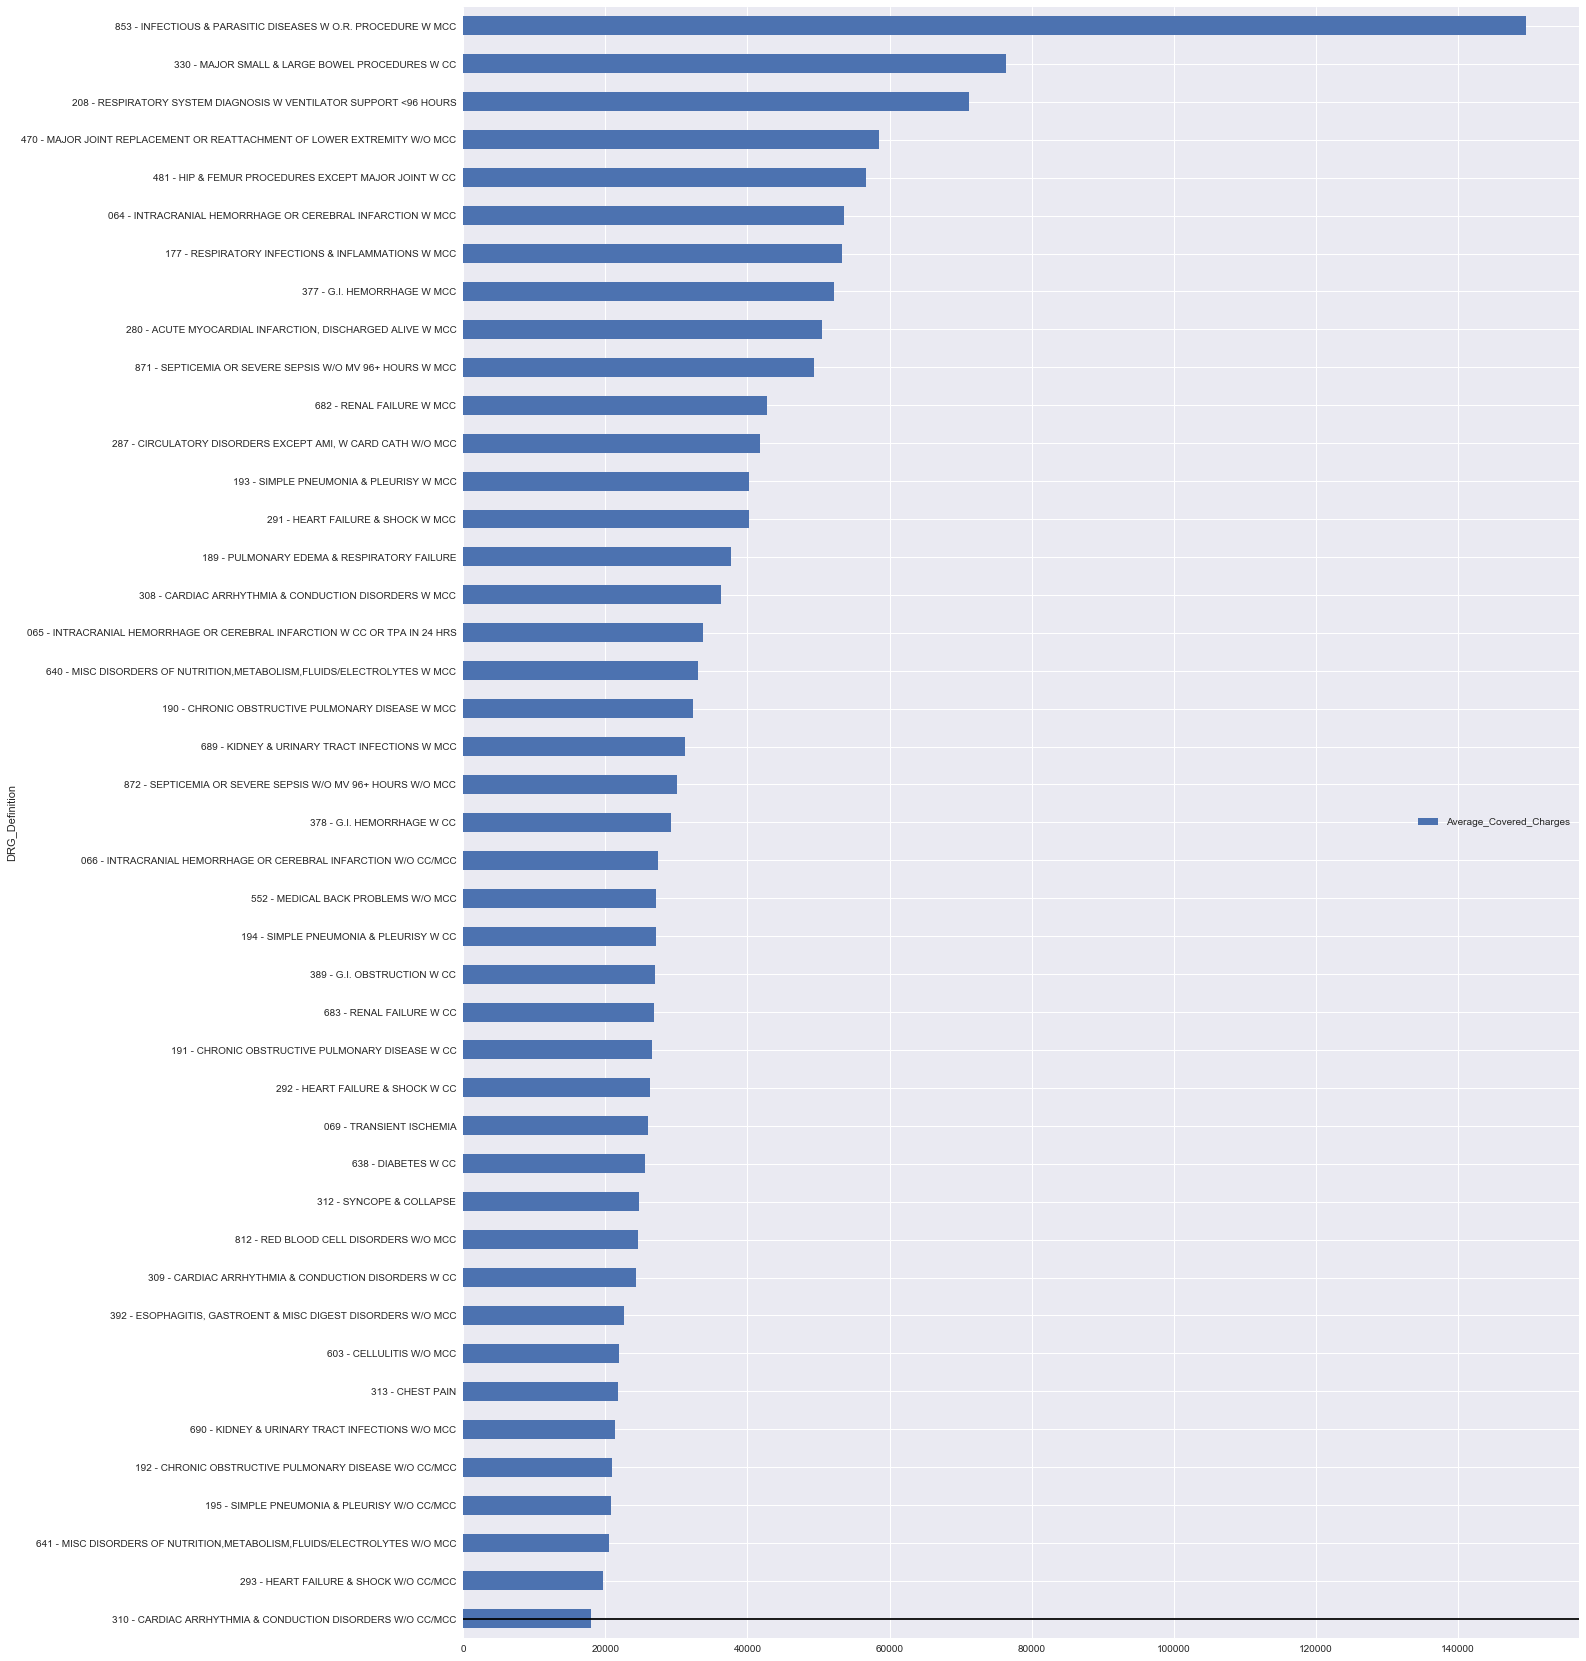

In [72]:
import matplotlib.pyplot as plt
df_inpt_only_top_plot_group.plot(kind='barh',figsize=(20,30)); plt.axhline(0, color='k')


If using dictionaries:

In [73]:
# #covered_charges_dict
# charges_plot = [item[0] for item in covered_charges_dict.values()]
# charges_keys = covered_charges_dict.keys()
# #total_payments_dict
# #medicare_payments_dict
# #patient_payments_dict.values()[10][1]
# Patient_payments_plot = [item[0] for item in patient_payments_dict.values()]
# Patient_payment_keys = patient_payments_dict.keys()

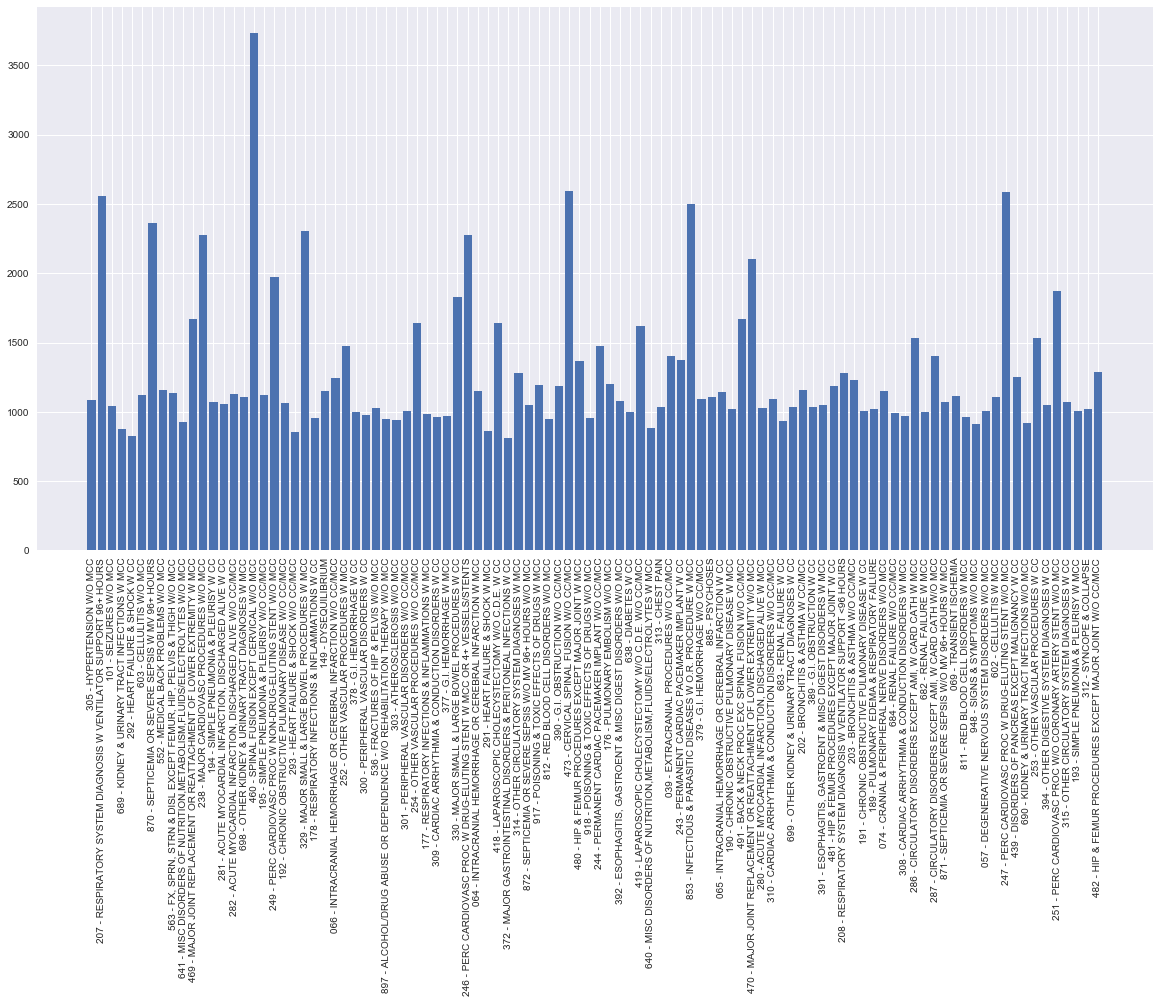

In [451]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,10))
# plt.bar(range(len(Patient_payment_keys)),Patient_payments_plot )
# plt.xticks(range(len(Patient_payment_keys)), list(patient_payments_dict.keys()), rotation = 'vertical')

# plt.show()